In [4]:
!unzip -qq archive_2.zip

Creating Train,validation and test sub directries

In [29]:
import os, shutil, pathlib

original_dir = pathlib.Path("./train/train/")
new_base_dir = pathlib.Path("./cats_vs_dogs_3000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=3000)
make_subset("validation", start_index=3000, end_index=3500)
make_subset("test", start_index=3500, end_index=4000)

Preprocessing Data

In [31]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(150, 150),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(150, 150),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(150, 150),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [32]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [33]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [34]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [35]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [36]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


Building the model

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(150, 150, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Model summary

In [38]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                      

In [39]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
188/188 [==============================] - 12s 43ms/step - loss: 0.6756 - accuracy: 0.5613 - val_loss: 0.6364 - val_accuracy: 0.6570
Epoch 2/30
188/188 [==============================] - 9s 49ms/step - loss: 0.5976 - accuracy: 0.6825 - val_loss: 0.5597 - val_accuracy: 0.7170
Epoch 3/30
188/188 [==============================] - 9s 49ms/step - loss: 0.5411 - accuracy: 0.7317 - val_loss: 0.5602 - val_accuracy: 0.7000
Epoch 4/30
188/188 [==============================] - 8s 43ms/step - loss: 0.4784 - accuracy: 0.7705 - val_loss: 0.4657 - val_accuracy: 0.7900
Epoch 5/30
188/188 [==============================] - 9s 48ms/step - loss: 0.4353 - accuracy: 0.8055 - val_loss: 0.4487 - val_accuracy: 0.7900
Epoch 6/30
188/188 [==============================] - 9s 48ms/step - loss: 0.3827 - accuracy: 0.8292 - val_loss: 0.4718 - val_accuracy: 0.7790
Epoch 7/30
188/188 [==============================] - 9s 48ms/step - loss: 0.3178 - accuracy: 0.8538 - val_loss: 0.4343 - val_accuracy: 0.803

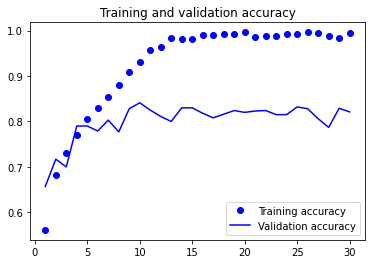

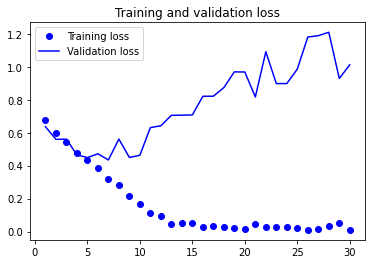

In [42]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [43]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 26ms/step - loss: 0.4629 - accuracy: 0.7780
Test accuracy: 0.778


Using Augmentation

In [44]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

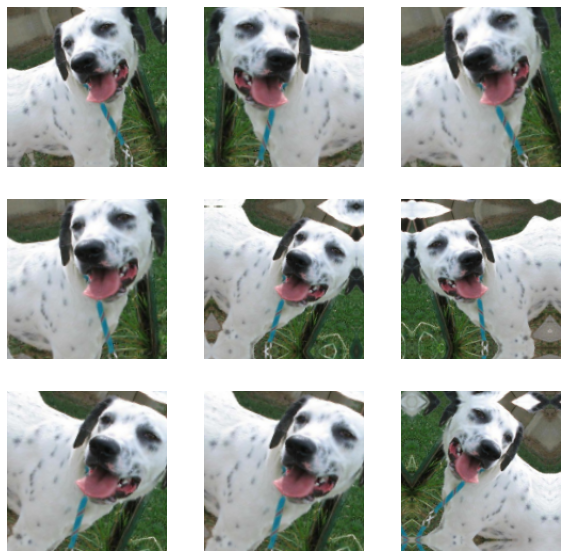

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [46]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


188/188 [==============================] - 39s 182ms/step - loss: 0.6941 - accuracy: 0.5068 - val_loss: 0.6922 - val_accuracy: 0.5020
Epoch 2/100
188/188 [==============================] - 34s 178ms/step - loss: 0.6910 - accuracy: 0.5213 - val_loss: 0.6894 - val_accuracy: 0.5230
Epoch 3/100
188/188 [==============================] - 34s 182ms/step - loss: 0.6942 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
188/188 [==============================] - 34s 182ms/step - loss: 0.6935 - accuracy: 0.4998 - val_loss: 0.6907 - val_accuracy: 0.5150
Epoch 5/100
188/188 [==============================] - 34s 178ms/step - loss: 0.6875 - accuracy: 0.5438 - val_loss: 0.6759 - val_accuracy: 0.5810
Epoch 6/100
188/188 [==============================] - 34s 182ms/step - loss: 0.6810 - accuracy: 0.5535 - val_loss: 0.6775 - val_accuracy: 0.5660
Epoch 7/100
188/188 [==============================] - 35s 183ms/step - loss: 0.6626 - accuracy: 0.6010 - val_loss: 0.6508 - val_accurac

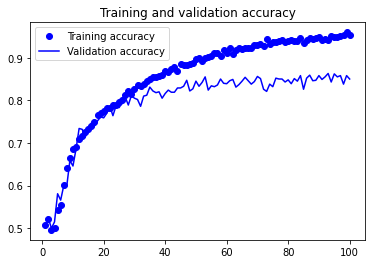

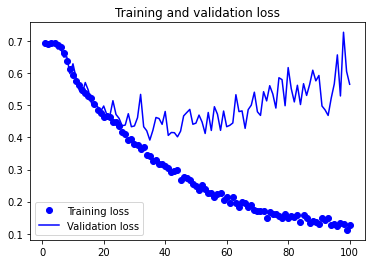

In [48]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [49]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 25ms/step - loss: 0.4473 - accuracy: 0.8190
Test accuracy: 0.819
